In [58]:
from jax.numpy import zeros, arange, exp, sin, array, pi
from ticktack import load_presaved_model

In [59]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

`jax.lax.scan` will let me make the most of the notes.

In [60]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    step_size = timesteps[1] - timesteps[0]
    output = zeros((y0.shape[0], timesteps.shape[0]))
    output[:, 0].scan(y0)   #! JAX from here.
    # scan will scip the for loop
    for j, step in enumerate(timesteps[:-1]):
        output.at[:, j+1].set(output[:, j] + step_size * derivative(output[:, j], timesteps[j]))
    return output 

In [61]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [62]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [63]:
time_out = arange(-500, 775)
oversample = 1008
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [64]:
odeint_sample, ode_next_y0 = carbon_box_model.run(time_out, oversample, \
    production, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)
lin_ode_sample, lin_next_y0 = carbon_box_model.run(time_out, oversample, \
    production, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [65]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(time_out, odeint_sample)
plt.plot(time_out, lin_ode_sample)
plt.xlim(650, 700)

In [ ]:
time_out = arange(750, 800)
oversample = 10

In [ ]:
odeint_sample_1, _ = carbon_box_model.run(time_out, oversample, \
    production, y0=ode_next_y0, args=parameters, \
    steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

lin_ode_sample_1, _ = carbon_box_model.run(time_out, oversample, \
    production, solver=odeint_linear, y0=lin_next_y0, args=parameters, \
    steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

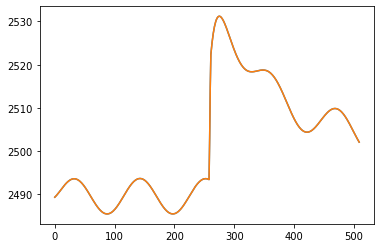

In [ ]:
plt.plot(odeint_sample_1[:, 1])
plt.plot(lin_ode_sample_1[:, 1])